In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from GPyEm import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

In [2]:
reps=5
nn=[20,30,40,50,60,80,100,120,140]
ylabels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/ylabels.txt',delim_whitespace=True,header=None)
xlabels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/LA_data/case01/xlabels.txt',delim_whitespace=True,header=None)
xlabels=xlabels.values.flatten().tolist()
ylabels=ylabels.values.flatten().tolist()

In [15]:
markers=['o',"v","^","s","x","h","p"]

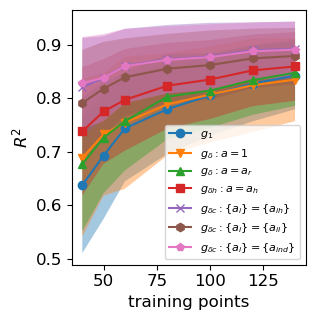

In [22]:
R2_s=pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/csv_files/DiscrepR2TrainNVaryDefinitiveAtria.csv",header=None).values.reshape(7,len(nn),7,reps)

plt.rcParams["figure.figsize"] = (3.3,3.3)
fontS=12


o=5
lim=2
lim2=15
y_lim=[0.5,1.01]


for i in range(R2_s.mean(axis=(2,3)).shape[0]):
    plt.plot(nn[lim:lim2],R2_s.mean(axis=(2,3))[i,lim:lim2].T,marker=markers[i])
    
#plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_i\}=\{a_{ih}\}$','$g_{\delta c}:\{a_i\}=\{a_{il}\}$','$g_{\delta c}: \{a_i\}=\{a_{ind}\}$'],prop={'size': 8})
for i in range(7):
    plt.fill_between(nn[lim:lim2], R2_s.mean(axis=(2,3))[i,lim:lim2]+R2_s.std(axis=(2,3))[i,lim:lim2], R2_s.mean(axis=(2,3))[i,lim:lim2]-R2_s.std(axis=(2,3))[i,lim:lim2],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.tight_layout()
plt.savefig('figures/Fig7.tiff',dpi=600 )



In [4]:
R2_s.mean(axis=(2,3))

array([[0.30604999, 0.5375662 , 0.63750242, 0.69275575, 0.74350597,
        0.77951108, 0.80516369, 0.82713909, 0.84202875],
       [0.512411  , 0.66055593, 0.68844993, 0.7323948 , 0.75388539,
        0.7885441 , 0.80660315, 0.82396999, 0.83456648],
       [0.45547793, 0.6243345 , 0.6767113 , 0.72610345, 0.75682861,
        0.80283576, 0.81398286, 0.83355743, 0.84742352],
       [0.56846864, 0.71349457, 0.7379936 , 0.77503925, 0.79682529,
        0.82319027, 0.8347429 , 0.85182965, 0.85916951],
       [0.71012472, 0.78934143, 0.82000899, 0.83795897, 0.860816  ,
        0.87260563, 0.8775083 , 0.88942168, 0.89185666],
       [0.63154332, 0.75603806, 0.79084979, 0.81779996, 0.83891036,
        0.85501093, 0.86170498, 0.87417102, 0.87879052],
       [0.71172417, 0.79654343, 0.82795822, 0.83808193, 0.85964999,
        0.87147796, 0.87655394, 0.88748786, 0.89047692]])

In [5]:
R2_s

array([[[[ 0.35988849,  0.2847248 ,  0.45125619,  0.41511631,
           0.31324965],
         [ 0.33606994,  0.30077067,  0.30563411,  0.40651563,
           0.22859465],
         [ 0.20124334,  0.08295811, -0.04040198,  0.07844754,
           0.05620307],
         ...,
         [-0.19301265,  0.35999241,  0.19599099,  0.15590544,
           0.11301643],
         [ 0.30936241,  0.21049821,  0.18031779,  0.16822496,
           0.23321396],
         [ 0.73561323,  0.74216604,  0.76380539,  0.68925446,
           0.73186332]],

        [[ 0.55921888,  0.59871298,  0.64552534,  0.55337435,
           0.50567073],
         [ 0.55671883,  0.37532699,  0.69430387,  0.57689333,
           0.52497756],
         [ 0.29886794,  0.41613904,  0.40217096,  0.39067721,
           0.28382212],
         ...,
         [ 0.51145357,  0.41971627,  0.49715957,  0.37863058,
           0.44479644],
         [ 0.40423623,  0.51185513,  0.3899413 ,  0.4723351 ,
           0.39801994],
         [ 0.77627128,  

(7, 7, 5)

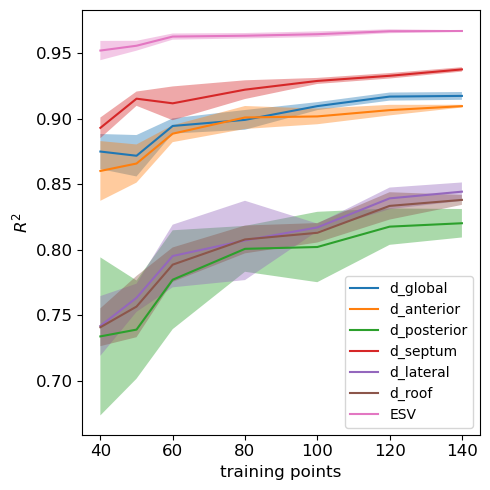

In [6]:
o=1
plt.plot(nn[lim:lim2],R2_s.mean(axis=(3))[6,lim:lim2])
#plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
#plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'])
plt.legend(ylabels)
for i in range(7):
    plt.fill_between(nn[lim:lim2], R2_s.mean(axis=3)[6,lim:lim2,i]+R2_s.std(axis=3)[6,lim:lim2,i], R2_s.mean(axis=3)[6,lim:lim2,i]-R2_s.std(axis=3)[6,lim:lim2,i],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.tight_layout()
plt.savefig('figures/WeavingDTDiscrepVTATAtria.pdf' )
#plt.axhline(y = 0.8, color = 'r', linestyle = '-') 
R2_s[:,3].shape



In [7]:
R2_s.mean(axis=(3)).shape

(7, 9, 7)

In [8]:
R2_s.mean(axis=(3))[6,lim:lim2].T

array([[0.87481762, 0.8716091 , 0.8943567 , 0.89899918, 0.9094943 ,
        0.91678497, 0.91730112],
       [0.86000497, 0.86567514, 0.88846228, 0.90082226, 0.90163264,
        0.90644794, 0.90947896],
       [0.73369763, 0.73888949, 0.77696664, 0.80054725, 0.80194067,
        0.81748811, 0.82008818],
       [0.89290472, 0.91517359, 0.9116309 , 0.92206154, 0.92873408,
        0.93264952, 0.93752624],
       [0.74167887, 0.76316535, 0.79507133, 0.80696028, 0.8168906 ,
        0.83906777, 0.84419261],
       [0.74068153, 0.75646435, 0.78846352, 0.80772145, 0.81278821,
        0.8333243 , 0.83790879],
       [0.95192223, 0.95559645, 0.96259855, 0.96323377, 0.96439708,
        0.96665244, 0.96684251]])

(7, 7, 5)

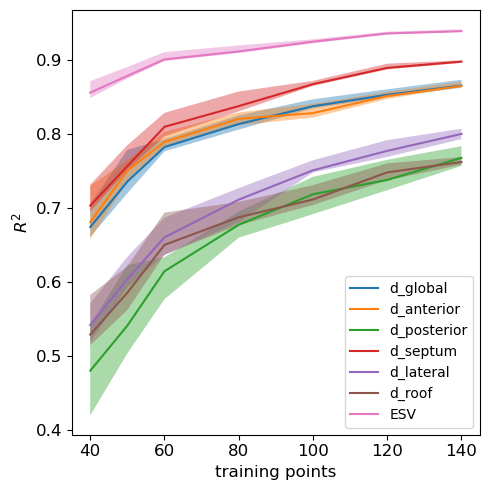

In [9]:
o=0
plt.plot(nn[lim:lim2],R2_s.mean(axis=(3))[o,lim:lim2])
#plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
#plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'])
plt.legend(ylabels)
for i in range(7):
    plt.fill_between(nn[lim:lim2], R2_s.mean(axis=3)[o,lim:lim2,i]+R2_s.std(axis=3)[o,lim:lim2,i], R2_s.mean(axis=3)[o,lim:lim2,i]-R2_s.std(axis=3)[6,lim:lim2,i],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.tight_layout()
plt.savefig('WeavingDTDiscrepVTATAtria.pdf' )

R2_s[:,3].shape

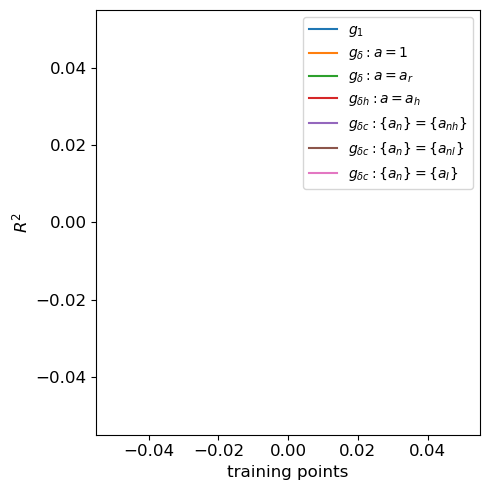

In [10]:
#R2_s=pd.read_csv("DiscrepR2TrainNVaryDefinitiveAtria.csv",header=None).values.reshape(7,len(nn),7,reps)

plt.rcParams["figure.figsize"] = (5,5)
fontS=12


o=0
lim=10
lim2=15
y_lim=[0.987,1.001]

plt.plot(nn[lim:lim2],R2_s.mean(axis=3)[:,lim:lim2,o].T)
#plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'])
for i in range(7):
    plt.fill_between(nn[lim:lim2], R2_s.mean(axis=3)[i,lim:lim2,o]+R2_s.std(axis=3)[i,lim:lim2,o], R2_s.mean(axis=3)[i,lim:lim2,o]-R2_s.std(axis=3)[i,lim:lim2,o],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.tight_layout()
plt.savefig('WeavingDTDiscrepATATHighAtria.pdf' )



(0.987, 1.001)

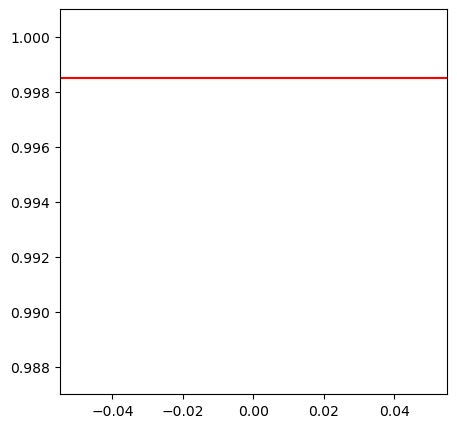

In [11]:
plt.plot(R2_s.mean(axis=3)[:,lim:lim2,o].T[:,6])
plt.axhline(y = 0.9985, color = 'r', linestyle = '-') 
plt.ylim(y_lim)

(7, 7, 5)

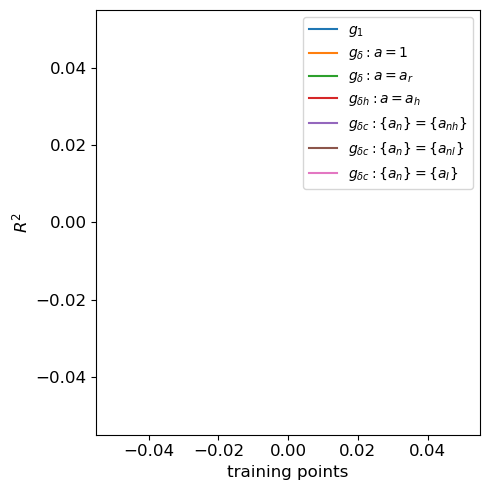

In [12]:
o=1
plt.plot(nn[lim:lim2],R2_s.mean(axis=3)[:,lim:lim2,o].T)
#plt.ylim(y_lim)
plt.ylabel('$R^2$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'])
for i in range(7):
    plt.fill_between(nn[lim:lim2], R2_s.mean(axis=3)[i,lim:lim2,o]+R2_s.std(axis=3)[i,lim:lim2,o], R2_s.mean(axis=3)[i,lim:lim2,o]-R2_s.std(axis=3)[i,lim:lim2,o],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)
plt.tight_layout()
plt.savefig('WeavingDTDiscrepVTATHighAtria.pdf' )

R2_s[:,3].shape



In [100]:
tpr=6

In [101]:
nn[tpr]

100

In [102]:
plt.rcParams["figure.figsize"] = (2,2)

nn

results=pd.DataFrame((R2_s[:,tpr ].mean(axis=2)))


results.index=['\$g_1\$','\$g_{\delta}:a=1\$','\$g_{\delta}:a=a_r\$','\$g_{\delta h}:a=a_h\$','\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$','\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$','\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$']

#results.columns=['A_TAT','V_TAT']

results.style.highlight_min(color = 'pink', axis = 0).highlight_max(color = 'lightgreen', axis = 0)

,0,1,2,3,4,5,6
\$g_1\$,0.837140,0.827807,0.718212,0.866951,0.750570,0.711129,0.924335
\$g_{\delta}:a=1\$,0.843466,0.824669,0.714990,0.886504,0.724971,0.704530,0.947091
\$g_{\delta}:a=a_r\$,0.828381,0.833769,0.747046,0.865648,0.757515,0.730941,0.934580
\$g_{\delta h}:a=a_h\$,0.861840,0.856274,0.757818,0.898977,0.773290,0.743250,0.951751
\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$,0.913840,0.907990,0.802385,0.929637,0.815383,0.809353,0.963969
\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$,0.895083,0.878118,0.782890,0.916874,0.808250,0.791596,0.959124
\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$,0.909494,0.901633,0.801941,0.928734,0.816891,0.812788,0.964397


In [103]:
ands=pd.DataFrame(['&','&','&','&','&','&','&'])

In [104]:
results = pd.DataFrame((R2_s[:,i ].mean(axis=2)))

In [105]:
results=pd.concat([ands,results.iloc[:,0],ands,results.iloc[:,1]],axis=1)

In [106]:
results = pd.DataFrame((R2_s[:,2 ].mean(axis=2)))
results=pd.concat([ands,results.iloc[:,0],ands,results.iloc[:,1]],axis=1)
for i in [6,10]:
    results1=pd.DataFrame((R2_s[:,i ].mean(axis=2)))
    results=pd.concat([results,ands,results1.iloc[:,0],ands,results1.iloc[:,1]],axis=1)
results.index=['\$g_1\$','\$g_{\delta}:a=1\$','\$g_{\delta}:a=a_r\$','\$g_{\delta h}:a=a_h\$','\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$','\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$','\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$']
    

IndexError: index 10 is out of bounds for axis 1 with size 9

In [107]:
results.round(3)

,0,0,0,1,0,0,0,1
0,&,0.674,&,0.680,&,0.837,&,0.828
1,&,0.747,&,0.730,&,0.843,&,0.825
2,&,0.725,&,0.730,&,0.828,&,0.834
3,&,0.784,&,0.777,&,0.862,&,0.856
4,&,0.865,&,0.859,&,0.914,&,0.908
5,&,0.837,&,0.819,&,0.895,&,0.878
6,&,0.875,&,0.860,&,0.909,&,0.902


In [108]:
t=np.array([[0.9958, 0.9964, 0.9958, 0.9946, 0.9967],[0.9920, 0.9889, 0.9895, 0.9912, 0.9888]])

In [109]:
t.mean(axis=1)

array([0.99586, 0.99008])

In [110]:
nn[13]

IndexError: list index out of range

In [111]:
results = pd.DataFrame((R2_s[:,12 ].mean(axis=2)))
results=pd.concat([ands,results.iloc[:,0],ands,results.iloc[:,1]],axis=1)
for i in [13,14]:
    results1=pd.DataFrame((R2_s[:,i ].mean(axis=2)))
    results=pd.concat([results,ands,results1.iloc[:,0],ands,results1.iloc[:,1]],axis=1)
results.index=['\$g_1\$','\$g_{\delta}:a=1\$','\$g_{\delta}:a=a_r\$','\$g_{\delta h}:a=a_h\$','\$g_{\delta c}:\{a_n\}=\{a_{nh}\}\$','\$g_{\delta c}:\{a_n\}=\{a_{nl}\}\$','\$g_{\delta c}: \{a_n\}=\{a_{I}\}\$']
    

IndexError: index 12 is out of bounds for axis 1 with size 9

In [112]:
0.884 0.876 0.743 0.889 0.836 0.781 0.945

SyntaxError: invalid syntax (411199783.py, line 1)

In [113]:
results.round(3)

,0,0,0,1,0,0,0,1
0,&,0.674,&,0.680,&,0.837,&,0.828
1,&,0.747,&,0.730,&,0.843,&,0.825
2,&,0.725,&,0.730,&,0.828,&,0.834
3,&,0.784,&,0.777,&,0.862,&,0.856
4,&,0.865,&,0.859,&,0.914,&,0.908
5,&,0.837,&,0.819,&,0.895,&,0.878
6,&,0.875,&,0.860,&,0.909,&,0.902


In [114]:
res=pd.DataFrame(R2_s[6].mean(axis=2))
res.index=nn
res.columns=ylabels
res.round(3).loc[[100]].mean(axis=1)

100    0.876571
dtype: float64

In [115]:
res=pd.DataFrame(R2_s[5].mean(axis=2))
res.index=nn
res.columns=ylabels
res.round(3).loc[[100]].mean(axis=1)

100    0.861714
dtype: float64

In [116]:
res=pd.DataFrame(R2_s[6].mean(axis=2))
res.index=nn
res.columns=ylabels
res.round(3).loc[[20,40,60,80,100,120,140]]

,d_global,d_anterior,d_posterior,d_septum,d_lateral,d_roof,ESV
20,0.737,0.718,0.621,0.803,0.590,0.593,0.919
40,0.875,0.860,0.734,0.893,0.742,0.741,0.952
60,0.894,0.888,0.777,0.912,0.795,0.788,0.963
80,0.899,0.901,0.801,0.922,0.807,0.808,0.963
100,0.909,0.902,0.802,0.929,0.817,0.813,0.964
120,0.917,0.906,0.817,0.933,0.839,0.833,0.967
140,0.917,0.909,0.820,0.938,0.844,0.838,0.967


In [117]:
ands=pd.DataFrame(['&','&','&','&','&','&','&'])

In [118]:
slashes=pd.DataFrame(['\\\\','\\\\','\\\\','\\\\','\\\\','\\\\','\\\\'])

In [119]:
slashes

,0
0,\\
1,\\
2,\\
3,\\
4,\\
5,\\
6,\\


In [120]:
R2_s[0].shape

(9, 7, 5)

In [121]:
R2_s[0].mean(axis=2).shape

(9, 7)

In [126]:
res=pd.DataFrame(R2_s[0].mean(axis=2))
res.index=nn
res.columns=ylabels
res1 = res.round(3).loc[[20,40,60,80,100,120,140]]
ands.index=res1.index
slashes.index=res1.index
ands.columns=['&']

In [127]:
res1.shape

(7, 7)

In [128]:
res2 = pd.concat([ands,res1.iloc[:,0]],axis=1)
for i in range (res1.shape[0]-1):
    n=i+1
    res2 = pd.concat([res2,ands,res1.iloc[:,n]],axis=1)
res2=pd.concat([res2,slashes],axis=1)    

In [129]:
res2

,&,d_global,&,d_anterior,&,d_posterior,&,d_septum,&,d_lateral,&,d_roof,&,ESV,0
20,&,0.365,&,0.316,&,0.076,&,0.307,&,0.126,&,0.220,&,0.733,\\
40,&,0.674,&,0.680,&,0.480,&,0.703,&,0.542,&,0.529,&,0.855,\\
60,&,0.782,&,0.789,&,0.614,&,0.809,&,0.660,&,0.650,&,0.900,\\
80,&,0.813,&,0.820,&,0.677,&,0.837,&,0.711,&,0.687,&,0.911,\\
100,&,0.837,&,0.828,&,0.718,&,0.867,&,0.751,&,0.711,&,0.924,\\
120,&,0.853,&,0.851,&,0.738,&,0.889,&,0.777,&,0.748,&,0.935,\\
140,&,0.865,&,0.864,&,0.767,&,0.897,&,0.800,&,0.762,&,0.939,\\


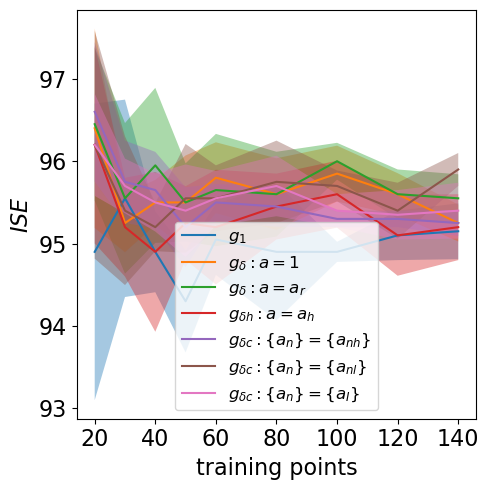

In [132]:
R2_s=pd.read_csv("/Users/pmzcwl/Documents/GitHub/Calibration/csv_files/DiscrepISETrainNVaryDefinitive.csv",header=None).values.reshape(7,len(nn),7,reps)

plt.rcParams["figure.figsize"] = (5,5)
fontS=16


o=0
lim=0
lim2=15


plt.plot(nn[lim:lim2],R2_s.mean(axis=3)[:,lim:lim2,o].T)

plt.ylabel('$ISE$',fontsize=fontS)
plt.xlabel('training points',fontsize=fontS)
plt.legend(['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}: \{a_n\}=\{a_{I}\}$'],prop={'size': 12})
for i in range(7):
    plt.fill_between(nn[lim:lim2], R2_s.mean(axis=3)[i,lim:lim2,o]+R2_s.std(axis=3)[i,lim:lim2,o], R2_s.mean(axis=3)[i,lim:lim2,o]-R2_s.std(axis=3)[i,lim:lim2,o],alpha=0.4)
    plt.xticks(fontsize=fontS)
plt.yticks(fontsize=fontS)

plt.tight_layout()

In [134]:
R2_s.min()

91.75

In [135]:
R2_s.max()

98.25